# Clustering: k-Means (k-Promedios)

Hoy veremos una clase de modelos de aprendizaje automático no supervisado: algoritmos de _agrupamiento_ (_clustering_).
Estos algoritms buscan aprender, desde las propiedades de los datos, una división óptima que permita etiquetar de manera discreta un conjunto de puntos.

En Scikit-Learn y en otras bibliotecas hay muchos algoritmos de clustering disponibles, pero quizás el más simple, y por eso, el mejor para comenzar, es _k-means_, que está implementado en el módulo ``sklearn.cluster.KMeans``.

Comencemos con el preámbulo estándar:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # para estilar los gráficos
import numpy as np

## Introducción a k-Means

El algoritmo _k-means_ busca un número predeterminado de grupos (_clusters_) dentro de un dataset multidimensional que no está etiquetado.
Lo hace a través de una definición simple de cómo se vería un clustering óptimo:

- El "centro de un grupo" tiene la posición promedio de todos los puntos que pertenecen al grupo.
- Cada punto está más cerca a su propio centro de grupo que al de otros grupos.

Estos dos supuestos son la base de un modelo _k-means_.
Pronto aprenderemos la manera exacta en la que el algoritmo encuentra esta solución, pero por ahora veamos un dataset simple y el resultado de aplicar el algoritmo.

Primero, generados un dato bidimensional que contenga cuatro grupos irregulares (_blobs_).
Para enfatizar que es un algoritmo no supervisado, dejaremos fuera de la visualización las etiquetas de cada grupo.

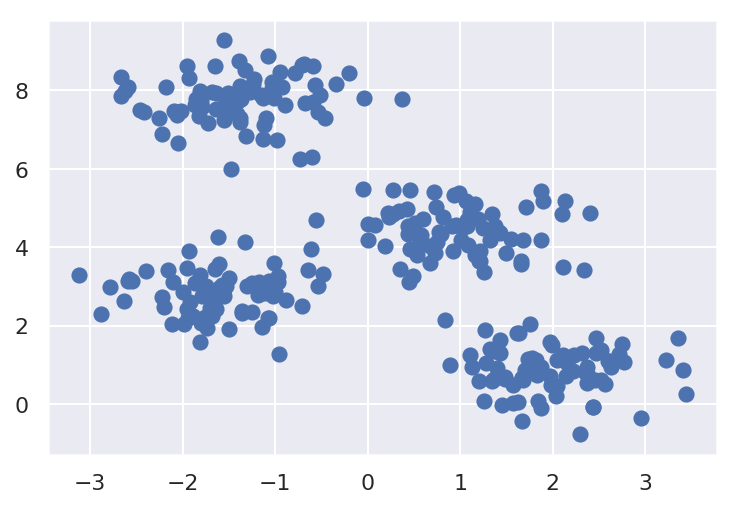

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Al ojo es relativamente fácil identificar los cuatro clusters.
El algoritmo lo hace automáticamente de la siguiente manera, siguiendo la API de estimadores típica de Scikit-Learn:

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Visualicemos los resultados coloreando los puntos con las etiquetas asignadas por el estimador.
Aprovecharemos también de mostrar los centros de cada cluster determinados por el algoritmo:

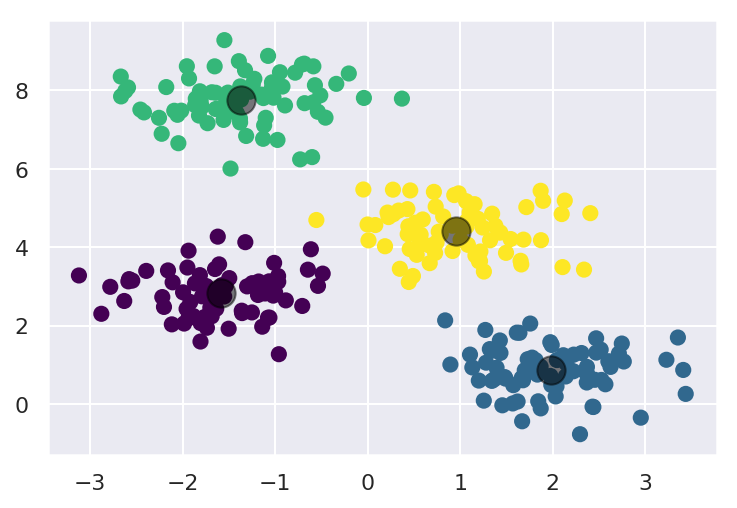

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Buenas noticias: el algoritmo _k-means_ asigna los centros de los clusters de manera muy similar a como lo haríamos nosotros manualmente, al menos en este caso.
¡Pero quizás te estás preguntando cómo es que el algoritmo encuentra los clusters tan rápido!
Después de todo, el número de posibles combinaciones de clusters es exponencial en el número de puntos en los datos-una búsqueda exhaustiva de la respuesta sería extremadamente costosa.
Afortunadamente para nosotros, una búsqueda exhaustiva no es necesaria. En cambio, el enfoque típico de _k-means_ involucra un enfoque iterativo bastante intuitivo, conocido como _expectación-maximización_ (_expectation-maximization_).

## Algoritmo k-Means: Expectación–Maximización

El algoritmo Expectación–maximización (E–M) es un método poderoso que aparece en una variedad de contextos dentro de la ciencia de datos.
_k-means_ es una aplicación particularmente simple y fácil de entender de la aplicación de este algoritmo. Ahora realizaremos un paso breve a través de él.
En resumen, el enfoque de expectación–maximización consiste en lo siguiente:

1. Adivina algunos centros de clusters.
2. Repetir hasta converger:
   1. *Paso–E*: asignar puntos al cluster más cercano.
   2. *Paso-M*: recalcular los centros de cada cluster como el promedio de los puntos pertenecientes al grupo.

El paso de expectación se llama así porque involucra actualizar nuestra expectativa sobre los clusters a los que pertenece cada punto.
El punto de maximización se llama así porque involucra maximizar el ajuste de alguna función objetivo que defina los centros de cada cluster–en este caso, la maximización se obtiene al estimar el promedio de todos los puntos que están en el cluster.

La literatura sobre este método es vasta, pero se puede resumir así: en circunstancias típicas, cada repetición del Paso-E y del Paso-M resultará siempre en una estimación mejor de las características del clustering.

Podemos visualizar el funcionamiento del algoritmo en la siguiente imagen. 
Para los datos que estamos utilizando, se converge al resultado en tan solo tres iteraciones.

![](figures/05.11-expectation-maximization.png)

_k-means_ es lo suficientemente simple como para que lo podamos implementar en unas cuantas líneas de ćodigo.
La siguiente es una implementación básica:

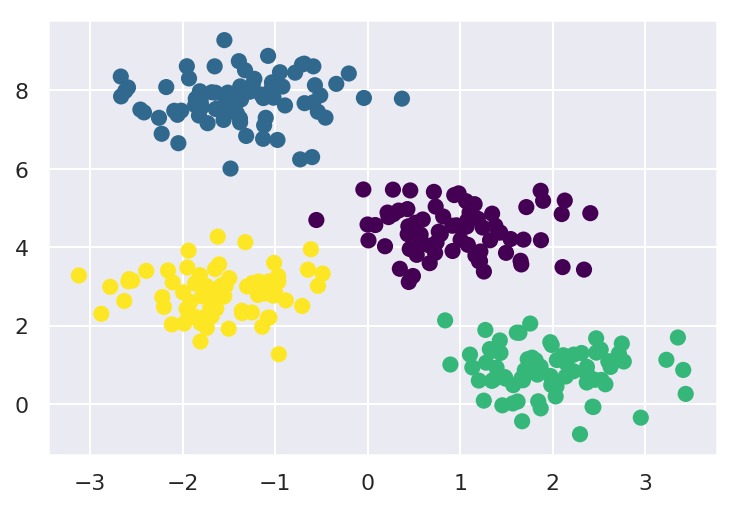

In [13]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Elegir centros de clusters al azar
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Asignar etiquetas (clusters) de acuerdo a distancias a los centros
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Encontrar nuevos centros con el promedio de los puntos de cada cluster
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Verificar convergencia
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Una buena implementación hace más cosas, pero la función que implementamos muestra la esencia del enfoque expectación–maximización.

### Consideraciones a tener en cuenta

Hay unos pocos asuntos de los cuales tenemos que estar al tanto cuando usemos expectación–maximización.

#### El óptimo global podría ser inalcanzable

Aunque cada paso de E–M garantiza mejorar los resultados, no hay garantías de que esa mejora lleve a la mejor solución _global_.
Por ejemplo, si usamos una semilla distinta para el generador de números aleatorios, los resultados son de peor calidad que en el ejemplo:

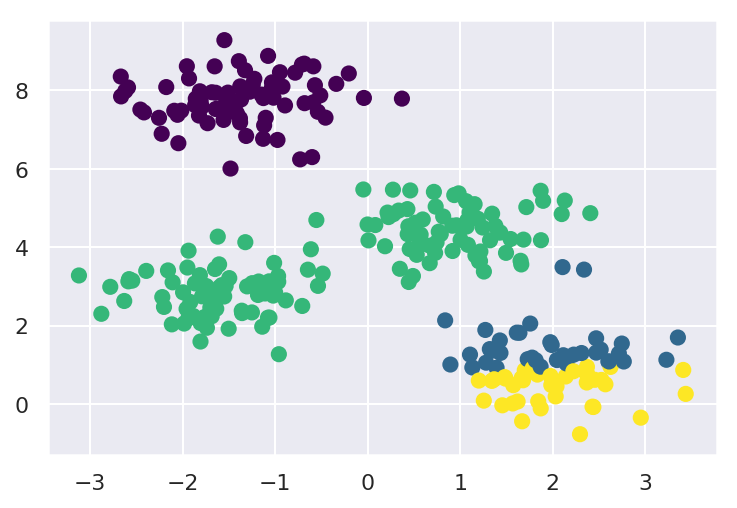

In [22]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Aunque el método convirgió, no lo hizo a una configuración óptima global. Por esta razón es común que el algoritmo se inicialice múltiples veces. Scikit-Learn hace esto por omisión (se configura con el hiperparámetro ``n_init``, que por omisión es 10).

#### El número de clusters debe ser elegido de antemano

Otro desafío común es que debes indicarle a _k-means_ un hiperparámetro con el número de clusters a estimar: no puede aprender esa cantidad desde los datos.
Por ejemplo,si le pedimos que encuentre seis clusters, los encontrarásin problema:

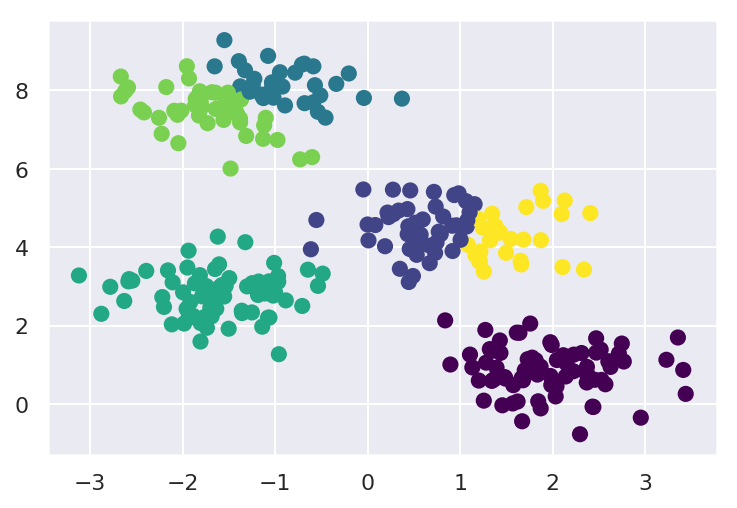

In [26]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

En efecto, son seis clusters bien definidos en función del funcionamiento del algoritmo, pero que tengan significado o sean coherentes con los datos es algo que no podemos responder de manera categórica. Una técnica que es intuitiva para determinar el número de clusters, pero que no discutiremos hoy, se llama [análisis de siluetas](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Otros algoritmos más complejos incluyen medidas de la calidad del ajuste (por ej., Gaussian mixture models), y otros _pueden_ elegir un número adecuado de clusters (por ej., DBSCAN, mean-shift, o _affinity propagation_, todos disponibles en el módulo ``sklearn.cluster``).

#### k-means está limitada a límites lineales entre los grupos

El supuesto fundamentales del modelo (que un punto estará más cerca del centro de su propio cluster que de los otros) significa que el algoritmo será ineficiente si los grupos tienen geometrías complicadas. 

En particular, los límites entre los clusters en _k-means_ siempre serán lineales, lo que quiere decir que si un grupo se separa por otro de manera compleja, el algoritmo fallará en identificar dicho borde.

Considera los siguientes datos y el resultado de aplicar _k-means_:

In [27]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

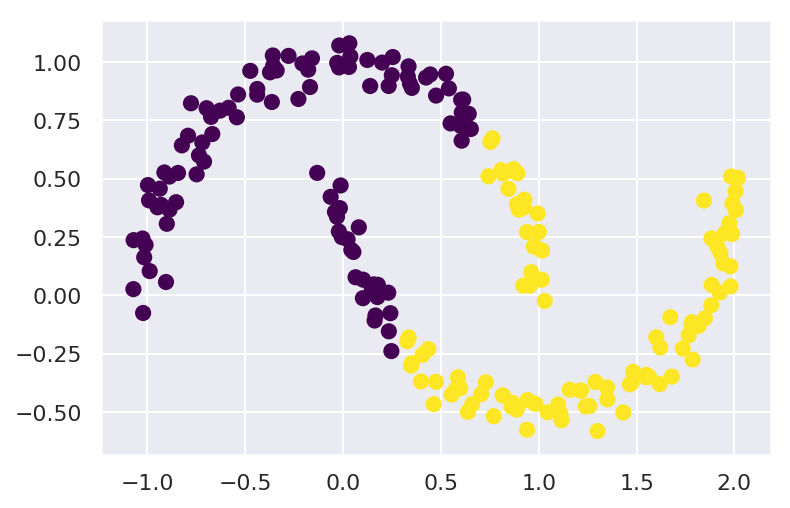

In [28]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

En otras técnicas como _Support Vector Machines_ se utilizan transformaciones que proyectan los datos a mayores dimensiones, que posibilitan una separación lineal de los datos.
Esta idea, llamado _kernel trick_, podría permitir que _k-means_ descubra límites no lineales.

El estimador que realiza esto se implementa en Scikit-Learn en la clase ``SpectralClustering``.
Usa un grafo de vecinos más cercanos para computar una representación altamente dimensional de los datos, y después asigna las etiquetas utilizando _k-means_:

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


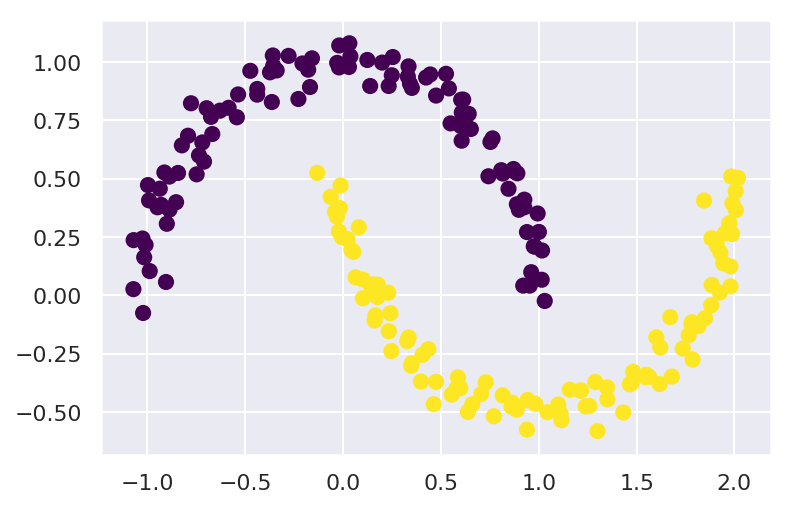

In [29]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Como podemos ver, con este uso de transformaciones el algoritmo _k-means_ puede encontrar bordes no lineales.

#### k-means puede ser lento para datasets grandes

Como cada iteración de _k-means_ hace un barrido por el dataset completo, el algoritmo puede ser relativamente lento a medida que crece el dataset.
Quizás te estás preguntando si el requisito de usar todos los puntos en cada iteración se puede relajar; por ejemplo, podrías utilizar un subconjunto de los datos para estimar los centros de los clusters en cada paso.

Ésa es la idea detrás de las implementaciones basadas en lotes de _k-means_. Una de ellas está disponible en ``sklearn.cluster.MiniBatchKMeans``, que utiliza la misma interfaz que la implementación estándar; veremos un ejemplo de esto más tarde.

## Ejemplos

Si conocemos las limitaciones del algoritmo, podemos utilizar _k-means_ de manera útil y ventajosa en una variedad de situaciones. Veremos algunos ejemplos ahora.

### Ejemplo 1: k-means en los dígitos

Para comenzar, veamos como funciona _k-means_ en los dígitos que hemos analizado anteriormente.
Intentaremos usar el algoritmo para identificar dígitos similares _sin utilizar las etiquetas originales_; esto podría ser similar a un primer paso en extraer significado de un dataset en una dimensión de la cual no tienes información _a priori_.

Primero cargaremos los dígitos y después calcularemos los _K_ clusters.
Recuerda que los dígitos tienen 1,797 muestras con 64 características, donde cada una de las 64 características es el brillo de un píxel en una imagen de 8×8:

In [30]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [31]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

El clustering se ejecuta tal como lo hicimos en el ejemplo:

In [33]:
kmeans.cluster_centers_[0]

array([ 0.00000000e+00, -9.99200722e-16,  3.07228916e-01,  7.16265060e+00,
        1.19457831e+01,  1.93373494e+00,  1.50602410e-01,  5.42168675e-02,
       -2.25514052e-17,  1.20481928e-02,  3.28313253e+00,  1.37951807e+01,
        8.46385542e+00,  1.53012048e+00,  9.75903614e-01,  2.77108434e-01,
       -1.12757026e-17,  6.44578313e-01,  1.07108434e+01,  1.15602410e+01,
        4.33734940e+00,  5.25903614e+00,  3.87349398e+00,  3.25301205e-01,
        6.02409639e-03,  4.75903614e+00,  1.47590361e+01,  5.86144578e+00,
        6.87951807e+00,  1.07530120e+01,  6.21686747e+00,  1.80722892e-02,
        0.00000000e+00,  8.92771084e+00,  1.48072289e+01,  9.35542169e+00,
        1.28132530e+01,  1.43915663e+01,  5.48192771e+00,  0.00000000e+00,
        9.63855422e-02,  6.50602410e+00,  1.16867470e+01,  1.23433735e+01,
        1.48373494e+01,  1.07590361e+01,  1.56626506e+00, -4.16333634e-17,
        6.02409639e-02,  1.11445783e+00,  3.00000000e+00,  7.77710843e+00,
        1.40843373e+01,  

In [32]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

Los centros de cada uno de los 10 clusters tienen, como esperamos, 64 dimensiones.
Es decir, podríamos interpretarlos como si fueran dígitos, y por tanto, visualizarlos y comprobar si se asemejan a lo que sería un "dígito promedio:"

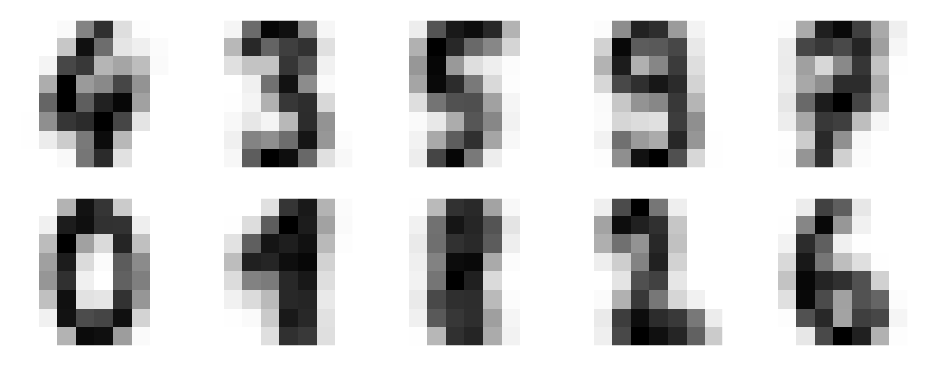

In [34]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))

centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Incluso _sin las etiquetas_, ``KMeans`` logró identificar clusters cuyos centros son reconocibles como dígitos, quizás con la excepción de 1 y 8.

Como _k-means_ no sabe nada sobre la identidad de cada cluster, las etiquetas desde 0 a 9 pueden estar desordenadas.
Podemos arreglar esto haciendo pareando cada etiqueta de cluster con las etiquetas verdaderas que conocemos:

In [35]:
from scipy.stats import mode

# un arreglo con etiquetas aprendidas, partimos solamente con ceros
labels = np.zeros_like(clusters)

for i in range(10):
    # máscara que elige a quienes estén en el cluster i
    mask = (clusters == i)
    # en el arreglo de etiquetas, ponemos el valor correspondiente a la máscara en los datos conocidos
    labels[mask] = mode(digits.target[mask])[0]

Teniendo ese pareo, podemos evaluar la precisión de nuestro aprendizaje no supervisado en la tarea de encontrar dígitos similares entre los datos:

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

¡Con un algoritmo _k-means_ simple descubrimos un agrupamiento correcto para el 80% de los datos!
Revisemos la matriz de confusión para explorar el comportamiento del algoritmo:

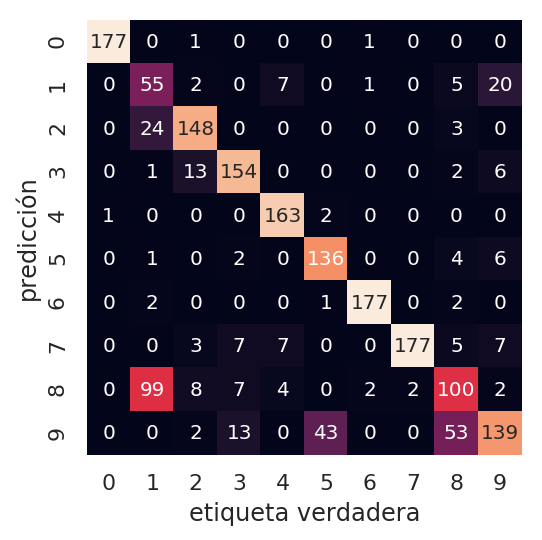

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('etiqueta verdadera')
plt.ylabel('predicción');

Como podríamos esperar de los dígitos promedio que visualizamos antes, el mayor punto de confusión se da entre ochos y unos.
Aún así, esto muestra que usando _k-means_ podemos construir un clasificador de dígitos _sin datos etiquetados previamente_.

Podemos experimentar un poco para ir más allá.
Usaremos un algoritmo de reducción dimensional conocido como t-SNE (_t-distributed stochastic neighbor embedding_) para pre-procesar los datos antes de ejecutar _k-means_. 
t-SNE es un algoritmo de _embedding_ no lineal que es particularmente bueno en preservar el agrupamiento de puntos dentro de clusters.

Entonces, primero realizaremos reducción dimensional de las imágenes, pasando de 64 características a dos.
Luego ejecutaremos _k-means_ en el espacio dimensional reducido.
Veamos:

In [38]:
from sklearn.manifold import TSNE

# Proyectamos los datos (esto se demora un poquito)
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Computamos los clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Pareamos las etiquetas
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Calculamos la precisión
accuracy_score(digits.target, labels)

0.9326655537006121

¡Casi 93% de precisión _sin utilizar etiquetas_!
Éste es el poder del aprendizaje no supervisado cuando se usa con cuidado: permite extraer información desde los datos que podría ser difícil de obtener a mano o al _ojímetro_.

### Ejemplo 2: *k-means* para compresión de color

Una aplicación interesante del clustering es la comprensión de color en imágenes.
Por ejemplo, imagina que tienes una imagen con un millón de colores.
En muchas imágenes, un gran número de píxeles puede tener colores idénticos o similares. Entonces, almacenarlos todos puede utilizar más espacio del requerido realmente.

Por ejemplo, considera la imagen mostrada abajo, que viene incluida en el módulo ``datasets`` (nota que para poder cargar la imagen necesitas el módulo ``pillow`` instalado).

In [ ]:
# Nota: esto requiere el módulo ``pillow`` instalado en el sistema
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

En sí misma, la imagen se almacena en un arreglo tridimensional de tamaño ``(alto, ancho, RGB)``, donde RGB contiene los canales rojo/azul/verde como tres números enteros desde 0 a 255:

In [ ]:
china.shape

Una manera de interpretar el dataset es como una nube de puntos en un espacio tridimensional, donde cada dimensión es un color.
Vamos a reformar los datos para que tengan el formato de una matriz de características ``[n_muestras x n_características]``, y escalaremos los colores de modo que sus valores vayan entre 0 y 1:

In [ ]:
data = china / 255.0 # colores entre 0...1
data = data.reshape(427 * 640, 3)
data.shape

Visualizaremos estos píxeles en este espacio de color, utilizando un subconjunto de 10000 píxeles para hacerlo de manera eficiente:

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # elegimos un subconjunto de N píxeles al azar
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Rojo', ylabel='Verde', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Rojo', ylabel='Azul', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [ ]:
plot_pixels(data, title='Espacio Dimensional de Entrada: 16 millones de colores posibles')

Ahora reduzcamos estos 16 millones de colores a solamente 16, utilizando _k-means_ a lo largo de espacio de los píxeles.
Como el dataset es grande, utilizaremos _k-means_ por lotes pequeños (``MiniBatchKMeans``), que opera en subconjuntos de los datos para computar los datos de manera más rápida:

In [ ]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Espacio de Color Reducido: 16 colores")

El resultado es una reasignación del color de los píxeles originales, donde cada píxel recibe el color del cluster más cercano.
Si dibujamos la imagen con este subconjunto reducido de colores, el resultado es el siguiente:

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Imagen Original', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('Imagen con 16 colores', size=16);

Aunque en la imagen comprimida de la derecha se pierden algunos detalles, la imagen en general es reconocible. ¡Además alcanza un factor de compresión cercano a un millón!

Ahora bien, existen mejores maneras de comprimir información en las imágenes. El ejemplo busca mostrar el poder de pensar fuera de la caja con métodos no supervisados como _k-means_.

## Créditos

![](figures/PDSH-cover.png)

Este notebook contiene un extracto del libro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; el contenido también está disponible en [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

El texto se distribuye bajo una licencia [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), y el código se distribuye bajo la licencia [MIT](https://opensource.org/licenses/MIT). Si te parece que este contenido es útil, por favor considera apoyar el trabajo [comprando el libro](http://shop.oreilly.com/product/0636920034919.do).

Traducción al castellano por [Eduardo Graells-Garrido](http://datagramas.cl), liberada bajo las mismas condiciones.